In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)


import os
pwd=os.environ['PWD']
pwd

'/root/nlp/dlwpt-code'

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [6]:
from torchvision import datasets, transforms
data_path = pwd + '/data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Using downloaded and verified file: /root/nlp/dlwpt-code/data-unversioned/p1ch6/cifar-10-python.tar.gz
Extracting /root/nlp/dlwpt-code/data-unversioned/p1ch6/cifar-10-python.tar.gz to /root/nlp/dlwpt-code/data-unversioned/p1ch6/


In [7]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [8]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [9]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [10]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [11]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [12]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [13]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [14]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [15]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [16]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

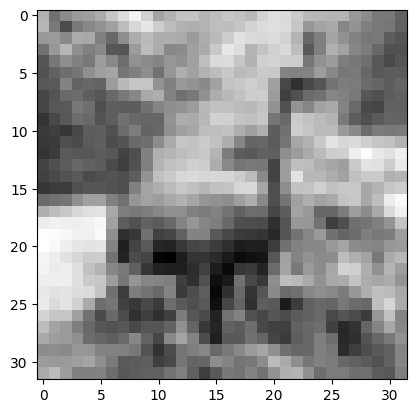

In [17]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

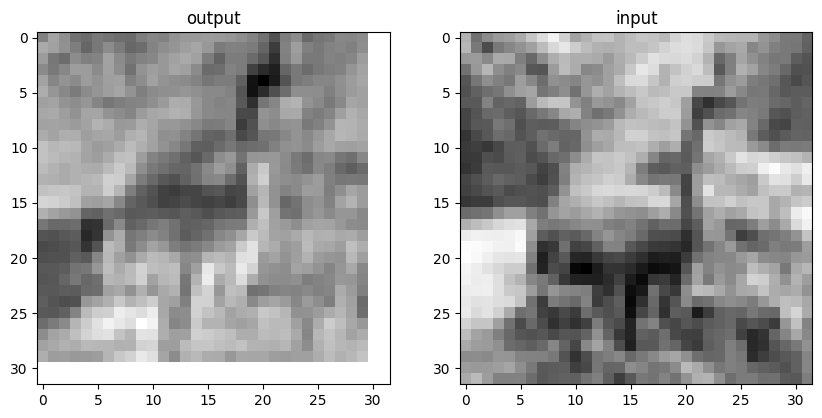

In [18]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [20]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

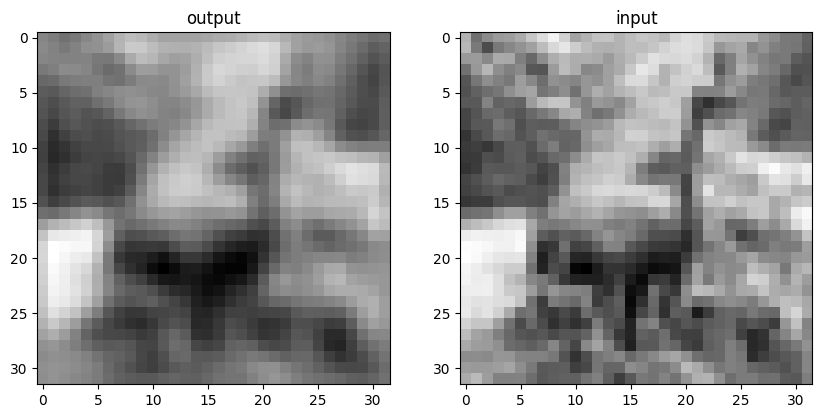

In [21]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [22]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

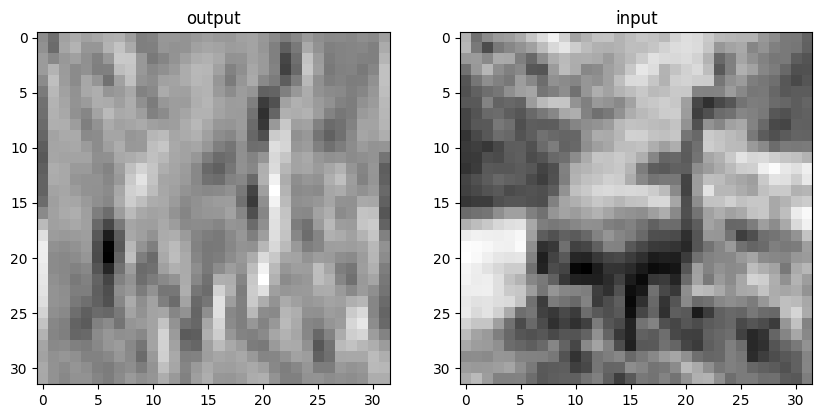

In [23]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [24]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [25]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [26]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [27]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [28]:
model(img.unsqueeze(0))

RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [28]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [29]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward>)

In [30]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [31]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-01-16 23:07:21.889707 Epoch 1, Training loss 0.5634813266954605
2020-01-16 23:07:37.560610 Epoch 10, Training loss 0.3277610331109375
2020-01-16 23:07:54.966180 Epoch 20, Training loss 0.3035225479086493
2020-01-16 23:08:12.361597 Epoch 30, Training loss 0.28249378549824855
2020-01-16 23:08:29.769820 Epoch 40, Training loss 0.2611226033253275
2020-01-16 23:08:47.185401 Epoch 50, Training loss 0.24105800626574048
2020-01-16 23:09:04.644522 Epoch 60, Training loss 0.21997178820477928
2020-01-16 23:09:22.079625 Epoch 70, Training loss 0.20370126601047578
2020-01-16 23:09:39.593780 Epoch 80, Training loss 0.18939699422401987
2020-01-16 23:09:57.111441 Epoch 90, Training loss 0.17283396527266046
2020-01-16 23:10:14.632351 Epoch 100, Training loss 0.1614033816868712


In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [33]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [34]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [35]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [36]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-01-16 23:10:35.563216 Epoch 1, Training loss 0.5717791349265227
2020-01-16 23:10:39.730262 Epoch 10, Training loss 0.3285350770137872
2020-01-16 23:10:45.906321 Epoch 20, Training loss 0.29493294959994637
2020-01-16 23:10:52.086905 Epoch 30, Training loss 0.26962305994550134
2020-01-16 23:10:56.551582 Epoch 40, Training loss 0.24709946277794564
2020-01-16 23:11:00.991432 Epoch 50, Training loss 0.22623272664892446
2020-01-16 23:11:05.421524 Epoch 60, Training loss 0.20996672821462534
2020-01-16 23:11:09.951312 Epoch 70, Training loss 0.1934866009719053
2020-01-16 23:11:14.499484 Epoch 80, Training loss 0.1799132404908253
2020-01-16 23:11:19.047609 Epoch 90, Training loss 0.16620008706761774
2020-01-16 23:11:23.590435 Epoch 100, Training loss 0.15667157247662544


In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [39]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

In [40]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [41]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2020-01-16 23:11:25.327462 Epoch 1, Training loss 0.5696582685989938
2020-01-16 23:11:29.501642 Epoch 10, Training loss 0.32219217129194055
2020-01-16 23:11:34.735670 Epoch 20, Training loss 0.2806013466636087
2020-01-16 23:11:40.264154 Epoch 30, Training loss 0.24591451655527588
2020-01-16 23:11:46.186918 Epoch 40, Training loss 0.21836834832741198
2020-01-16 23:11:51.856774 Epoch 50, Training loss 0.1943585573677804
2020-01-16 23:11:57.697704 Epoch 60, Training loss 0.1715057151522606
2020-01-16 23:12:03.421155 Epoch 70, Training loss 0.1487851360231448
2020-01-16 23:12:09.117316 Epoch 80, Training loss 0.12702234032427429
2020-01-16 23:12:14.856157 Epoch 90, Training loss 0.10666295210979167
2020-01-16 23:12:20.585829 Epoch 100, Training loss 0.08831981746301909
Accuracy train: 0.96
Accuracy val: 0.89


{'train': 0.9633, 'val': 0.89}

In [42]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [43]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2020-01-16 23:12:22.646242 Epoch 1, Training loss 0.5444508081029176
2020-01-16 23:12:26.841887 Epoch 10, Training loss 0.31707597633076323
2020-01-16 23:12:31.310813 Epoch 20, Training loss 0.27454944429503886
2020-01-16 23:12:35.891615 Epoch 30, Training loss 0.2425653456123012
2020-01-16 23:12:40.420664 Epoch 40, Training loss 0.21338120942852298
2020-01-16 23:12:44.954698 Epoch 50, Training loss 0.18698934290059813
2020-01-16 23:12:49.527939 Epoch 60, Training loss 0.16319987830367816
2020-01-16 23:12:54.380134 Epoch 70, Training loss 0.14089395708529054
2020-01-16 23:12:59.247492 Epoch 80, Training loss 0.11998948957889703
2020-01-16 23:13:04.068846 Epoch 90, Training loss 0.10076516851260783
2020-01-16 23:13:08.913110 Epoch 100, Training loss 0.0832248356217032
Accuracy train: 0.96
Accuracy val: 0.90


In [44]:
sum(p.numel() for p in model.parameters())

38386

In [45]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [46]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2020-01-16 23:13:10.225792 Epoch 1, Training loss 0.584277889151482
2020-01-16 23:13:17.795340 Epoch 10, Training loss 0.36633389723149073
2020-01-16 23:13:26.277897 Epoch 20, Training loss 0.3225795095133933
2020-01-16 23:13:35.341923 Epoch 30, Training loss 0.29615209541123383
2020-01-16 23:13:44.351376 Epoch 40, Training loss 0.2775719240782367
2020-01-16 23:13:53.296178 Epoch 50, Training loss 0.2636590329514947
2020-01-16 23:14:02.220169 Epoch 60, Training loss 0.2515565001755763
2020-01-16 23:14:11.076573 Epoch 70, Training loss 0.24007968713713299
2020-01-16 23:14:20.807501 Epoch 80, Training loss 0.22931366546708307
2020-01-16 23:14:31.504612 Epoch 90, Training loss 0.21898466424577556
2020-01-16 23:14:41.934048 Epoch 100, Training loss 0.20924225397360552
Accuracy train: 0.90
Accuracy val: 0.87


In [47]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [48]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2020-01-16 23:14:42.863912 Epoch 1, Training loss 0.5800061457476039
2020-01-16 23:14:47.868802 Epoch 10, Training loss 0.38074702850192976
2020-01-16 23:14:53.145910 Epoch 20, Training loss 0.34908065987620385
2020-01-16 23:14:58.056904 Epoch 30, Training loss 0.32977743029214773
2020-01-16 23:15:03.131635 Epoch 40, Training loss 0.3125769621247699
2020-01-16 23:15:08.321374 Epoch 50, Training loss 0.29207915010725616
2020-01-16 23:15:13.535053 Epoch 60, Training loss 0.28212467301043737
2020-01-16 23:15:18.876606 Epoch 70, Training loss 0.2723999054758412
2020-01-16 23:15:24.114116 Epoch 80, Training loss 0.2627566327714616
2020-01-16 23:15:29.342708 Epoch 90, Training loss 0.2537129214804643
2020-01-16 23:15:34.594518 Epoch 100, Training loss 0.23995957129700168
Accuracy train: 0.89
Accuracy val: 0.88


In [49]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [50]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2020-01-16 23:15:35.691938 Epoch 1, Training loss 0.4739942996744897
2020-01-16 23:15:40.475810 Epoch 10, Training loss 0.25983829872243724
2020-01-16 23:15:45.771541 Epoch 20, Training loss 0.19428231121058676
2020-01-16 23:15:51.089952 Epoch 30, Training loss 0.14371838975863852
2020-01-16 23:15:56.515419 Epoch 40, Training loss 0.101108748762376
2020-01-16 23:16:01.824733 Epoch 50, Training loss 0.06699353904955706
2020-01-16 23:16:07.094885 Epoch 60, Training loss 0.041509037291642965
2020-01-16 23:16:12.655136 Epoch 70, Training loss 0.032447671671961525
2020-01-16 23:16:18.188782 Epoch 80, Training loss 0.017081547878492788
2020-01-16 23:16:23.578206 Epoch 90, Training loss 0.011301719506455076
2020-01-16 23:16:28.884481 Epoch 100, Training loss 0.007566932796435371
Accuracy train: 1.00
Accuracy val: 0.89


In [51]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [52]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2020-01-16 23:16:30.447670 Epoch 1, Training loss 0.6548013091087341
2020-01-16 23:16:35.367838 Epoch 10, Training loss 0.34000502014236084
2020-01-16 23:16:40.826647 Epoch 20, Training loss 0.30152006637138923
2020-01-16 23:16:46.217950 Epoch 30, Training loss 0.2726998861618103
2020-01-16 23:16:51.688735 Epoch 40, Training loss 0.24409755509180628
2020-01-16 23:16:57.099919 Epoch 50, Training loss 0.21648093004515218
2020-01-16 23:17:02.744809 Epoch 60, Training loss 0.19037676303629664
2020-01-16 23:17:08.267520 Epoch 70, Training loss 0.16683378478713856
2020-01-16 23:17:13.854005 Epoch 80, Training loss 0.14403212810777555
2020-01-16 23:17:19.896823 Epoch 90, Training loss 0.12033685920819355
2020-01-16 23:17:25.857992 Epoch 100, Training loss 0.09564469111668077
Accuracy train: 0.95
Accuracy val: 0.90


In [53]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2020-01-16 23:17:26.950170 Epoch 1, Training loss 0.6650038665267313
2020-01-16 23:17:32.211548 Epoch 10, Training loss 0.3292607384122861
2020-01-16 23:17:37.607961 Epoch 20, Training loss 0.2860302617595454
2020-01-16 23:17:43.125477 Epoch 30, Training loss 0.2551692724227905
2020-01-16 23:17:48.706900 Epoch 40, Training loss 0.22809805450545753
2020-01-16 23:17:54.233746 Epoch 50, Training loss 0.20181633408661862
2020-01-16 23:17:59.702800 Epoch 60, Training loss 0.17625007239781368
2020-01-16 23:18:05.151562 Epoch 70, Training loss 0.15140700171802454
2020-01-16 23:18:10.695097 Epoch 80, Training loss 0.1257421809491838
2020-01-16 23:18:16.346922 Epoch 90, Training loss 0.09920599323454177
2020-01-16 23:18:22.144790 Epoch 100, Training loss 0.07639109212786528
Accuracy train: 0.97
Accuracy val: 0.90


In [55]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [56]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    


In [57]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2020-01-16 23:18:30.438073 Epoch 1, Training loss 2.2735002310412704
2020-01-16 23:19:39.382842 Epoch 10, Training loss 0.3779076840847161
2020-01-16 23:20:55.438525 Epoch 20, Training loss 0.3001826848763569
2020-01-16 23:22:12.180387 Epoch 30, Training loss 0.24923191243296217
2020-01-16 23:23:29.717063 Epoch 40, Training loss 0.20788565244834134
2020-01-16 23:24:45.533130 Epoch 50, Training loss 0.15866709291745143
2020-01-16 23:26:01.732320 Epoch 60, Training loss 0.12134665039599321
2020-01-16 23:27:17.569136 Epoch 70, Training loss 0.08729177155787018
2020-01-16 23:28:33.241105 Epoch 80, Training loss 0.07246267570740288
2020-01-16 23:29:49.378612 Epoch 90, Training loss 0.05779321811156003
2020-01-16 23:31:05.654037 Epoch 100, Training loss 0.06602069945222917
Accuracy train: 0.97
Accuracy val: 0.86


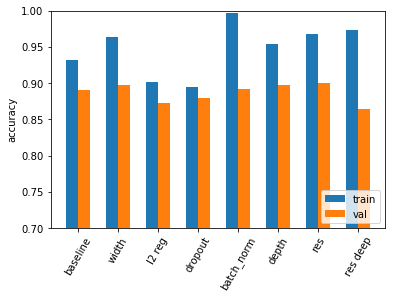

In [58]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()
